# Setup environment

In [ ]:
# !pip install transformers  datasets   torch-summary  jiwer torchaudio   wandb >ou 


In [ ]:
# !pip install https://github.com/kpu/kenlm/archive/master.zip >ou

In [ ]:
# !pip install pyctcdecode >ou

In [1]:

from dataclasses import dataclass, field
from tqdm import  tqdm
# import wandb

import torch
from torch.utils.data import  DataLoader
from torch import nn, optim,Tensor


# from torchsummary import summary
import torchaudio
import torchaudio.transforms as T


import transformers
from transformers import (
    Trainer,
    TrainingArguments,
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,


)

from copy import deepcopy
from typing import Any, Dict, List, Optional, Union,Tuple
# import jiwer
from inference import Inference

import numpy as np

from datasets  import load_metric
import IPython.display as ipd

from dataset import SemiSupervisedDataset,DatasetValidated

torchaudio.set_audio_backend('soundfile')

c:\Users\quang\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


C:\Users\quang\AppData\Local\Temp\ipykernel_10136\2331113631.py:37: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend('soundfile')


In [ ]:
name_version="Student_gen_1"
# !wandb login --relogin a19ac0b8d3d00acd9062764a8ac2e6d7cebb9ee1
# %env WANDB_PROJECT=ASR_with_NST
# wandb.init(project='ASR_with_NST', name=f"{name_version}")

In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [4]:
# model_name_student = "nguyenvulebinh/wav2vec2-base-vietnamese-250h"
model_name_student = "/kaggle/input/student-base-gen-1/Student_base/checkpoint-26500"

model_name_teacher="checkpoint\checkpoint_Teacher"
batch_size = 32
batch_size_text = 8

# lr = 0.0005 * batch_size ** (1 / 2)
lr = 0.000001
max_epochs = 10

processor = Wav2Vec2Processor.from_pretrained("nguyenvulebinh/wav2vec2-base-vietnamese-250h")

# labels=list(dict(sorted(processor.tokenizer.get_vocab().items(), key=lambda item: item[1])))
# decoder=build_ctcdecoder(labels=labels,
#             kenlm_model_path='/kaggle/input/pretrain/vi_lm_4grams.bin',
#             alpha = 0.5,
#             beta= 1.5,
#             unk_score_offset=-10.0,
#             lm_score_boundary=True,)
# processor_LM = Wav2Vec2ProcessorWithLM(
#             feature_extractor=processor.feature_extractor,
#             tokenizer=processor.tokenizer,
#             decoder=self.decoder)

In [ ]:

train_dataset = SemiSupervisedDataset(
    processor,
)
test_dataset=DatasetValidated(  
    processor,
    path='/kaggle/input/commonvoice-vie/cv-corpus-15.0-2023-09-08',
    path_csv='/kaggle/input/datacsv/commonvoice_test.csv'
)
val_dataset=DatasetValidated(  
    processor,
)

In [6]:
train_dataset[50001]

{'input_values': array([-0.07654735, -0.18226285,  0.10960388, ..., -0.38565034,
        -0.2613197 , -0.23925732], dtype=float32),
 'labels': [49,
  71,
  105,
  46,
  98,
  71,
  53,
  46,
  71,
  69,
  98,
  46,
  15,
  102,
  57,
  46,
  56,
  71,
  21,
  57,
  46,
  58,
  57,
  17,
  26]}

In [8]:
class DataCollatorTeacherCTCWithPadding:
    def __init__(
        self,
        processor:Wav2Vec2Processor,
        teacher:Inference,
        padding: Union[bool, str] = True,
        max_length: Optional[int] = None,
        max_length_labels: Optional[int] = None,
        pad_to_multiple_of: Optional[int] = None,
        pad_to_multiple_of_labels: Optional[int] = None,
    ):
        self.processor=processor
        self.teacher=teacher
        self.padding=padding
        self.max_length=max_length
        self.max_length_labels=max_length_labels
        self.pad_to_multiple_of=pad_to_multiple_of
        self.pad_to_multiple_of_labels=pad_to_multiple_of_labels
    def __call__(self, batchs: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": batch["input_values"]} for batch in batchs]
        label_features = [{"input_ids": batch["labels"]} for batch in batchs]
        mask_unlabel=[len(label_feature['input_ids'])==0 for label_feature in label_features]
        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",

        )
        pre_values=batch["input_values"][torch.tensor(mask_unlabel)]
        if len(pre_values)>0:
            label_pre=self.teacher.bach_predict(pre_values,30)
            label_pre=self.processor(text=label_pre).input_ids
        for i,mask in  enumerate(mask_unlabel):
            if mask:
                label_features[i]["input_ids"]=label_pre.pop(0)
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
    
            )
        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        batch["input_values"]= batch["input_values"]
       
        return batch
    
class DataCollatorCTCWithPadding:
    def __init__(
        self,
        processor:Wav2Vec2Processor,
        padding: Union[bool, str] = True,
        max_length: Optional[int] = None,
        max_length_labels: Optional[int] = None,
        pad_to_multiple_of: Optional[int] = None,
        pad_to_multiple_of_labels: Optional[int] = None,
    ):
        self.processor=processor
        self.padding=padding
        self.max_length=max_length
        self.max_length_labels=max_length_labels
        self.pad_to_multiple_of=pad_to_multiple_of
        self.pad_to_multiple_of_labels=pad_to_multiple_of_labels
    def __call__(self, batchs: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": batch["input_values"]} for batch in batchs]
        label_features = [{"input_ids": batch["labels"]} for batch in batchs]
        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",

        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
    
            )
        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        batch["input_values"]= batch["input_values"]
        return batch


In [7]:
teacher = Wav2Vec2ForCTC.from_pretrained(model_name_teacher)
teacher.to(device)
teacher.freeze_feature_encoder()
# print(model)
# print(summary(model,input_size= (1, 500)))

Some weights of the model checkpoint at checkpoint\checkpoint_Teacher were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at checkpoint\checkpoint_Teacher and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this mo

In [8]:
teacher_inference=Inference(teacher,processor)

Unigrams not provided and cannot be automatically determined from LM file (only arpa format). Decoding accuracy might be reduced.
No known unigrams provided, decoding results might be a lot worse.
c:\Users\quang\Desktop\AllDemo_dev\NLP\Wav2vec2NST_ASR\inference.py:26: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.wer_metric = load_metric("wer")


In [13]:
data_collator = DataCollatorTeacherCTCWithPadding(processor=processor,teacher=teacher_inference, padding=True)
data_collator_test = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [14]:
# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     collate_fn=data_collator,
#     shuffle=True,
#     pin_memory=True,
#     num_workers=0,
#     drop_last=False,
# )
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size_text,
    collate_fn=data_collator_test,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    drop_last=False,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size_text,
    collate_fn=data_collator_test,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    drop_last=False,
)

In [15]:
len(train_dataset)

72703

In [ ]:
# for d in tqdm(train_dataloader):
#     pass
#     break


In [36]:
student = Wav2Vec2ForCTC.from_pretrained(model_name_student)
student.to(device)
student.freeze_feature_encoder()
# print(model)
# print(summary(model,input_size= (1, 500)))

In [17]:
wer_metric = load_metric("wer")
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)

    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
config = {
    "model_teacher":model_name_student,
    "model_student":model_name_teacher,
    "learning_rate": lr,
    "max_epochs": max_epochs,
    "batch_size":  batch_size,
    "dataset":"VLSP"
}
# wandb.config = config

In [ ]:
repo_name="Student_base"
training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size =8,
  evaluation_strategy="steps",
  num_train_epochs=max_epochs,
  fp16=True,
  use_cpu=False,
  gradient_checkpointing=True, 
  save_steps=500,
  eval_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  do_train =True,
  save_total_limit=2,
  report_to="wandb", 
  run_name=f"{name_version}", 
  logging_steps=50,
  warmup_steps=500,
  logging_strategy='epoch'
   )

In [ ]:
total_steps=int((len(train_dataset)//batch_size+1)*max_epochs)
optimizer = optim.AdamW(student.parameters(), lr=lr, betas=(0.9, 0.9999))
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.0005, pct_start=0.3, total_steps=total_steps
)
print(total_steps)

In [ ]:
trainer = Trainer(
    model=student,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor.feature_extractor,
    optimizers =[optimizer,scheduler],
)

In [ ]:
trainer.train()
# wandb.finish()

In [32]:
# inference=Inference(student,processor)

In [34]:
# running_wers=inference.test_wer(test_dataloader)
# print(np.mean(running_wers))

1.0014178219486491


In [ ]:
# running_wers=teacher_inference.test_wer(test_dataloader,50)
# print(np.mean(running_wers))

In [42]:
# def lenghtLabel(sentence):
#     return len(sentence.split(' '))
# labels=list(dict(sorted(processor.tokenizer.vocab.items(), key=lambda item: item[1])))
# decoder=build_ctcdecoder(labels=labels,
#     kenlm_model_path='/kaggle/input/4-gram-vietnam/vi_lm_4grams.bin',
#     alpha = 0.5,
#     beta= 1.5,
#     unk_score_offset=-10.0,
#     lm_score_boundary=True,)
# def withtLM(logits,beam_width=100):
#     pool=get_context('spawn').Pool(2)
#     pred_strs=decoder.decode_batch(pool,logits.cpu().detach().numpy(), beam_width=beam_width)
#     return pred_strs
# wer_metric = load_metric("wer")
# running_wers=[]

# for batch in tqdm(test_dataloader,desc="Processing"):
#     with torch.no_grad():
#         pred=student(batch['input_values'].to(device))
#     pred_logits = pred.logits
#     pred_str=withtLM(pred_logits,50)
#     # we do not want to group tokens when computing the metrics
#     batch['labels'][batch['labels']== -100] = processor.tokenizer.pad_token_id
#     label_str = processor.batch_decode(batch['labels'], group_tokens=False)
#     lenlabels=list(map(lenghtLabel,label_str))
#     wer=[jiwer.wer(truth, hypot)for truth, hypot in zip(label_str, pred_str)]
#     [running_wers.append({i[0]:i[1]})for i in zip(lenlabels,wer)]
    
# grouped_data = {}
# for item in running_wers:
#     key = list(item.keys())[0]
#     value = list(item.values())[0]
    
#     if key not in grouped_data:
#         grouped_data[key] = [value]
#     else:
#         grouped_data[key].append(value)
# for key, values in grouped_data.items():
#     grouped_data[key]= np.mean(values)

Processing:   0%|          | 0/587 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Processing: 100%|██████████| 587/587 [03:54<00:00,  2.50it/s]


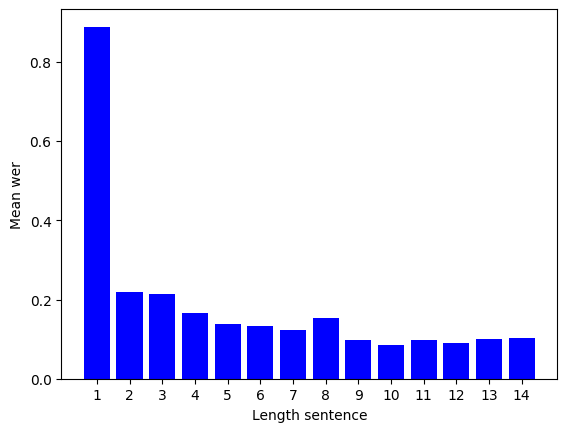

In [63]:
# import matplotlib.pyplot as plt
# keys = list(grouped_data.keys())
# values = list(grouped_data.values())

# plt.bar(keys, values, color='blue')
# plt.xlabel('Length sentence')
# plt.ylabel('Mean wer')
# plt.xticks(keys) 
# # plt.title('')
# plt.show()